In [16]:
import openmc
import numpy as np
import matplotlib.pyplot as plt

In [17]:
"""Define the geometry of the 'Fuel' Assembly"""

# Measurements from Schnitzler et al. 2012
propellant_channel_diameter = 0.2565
propellant_channel_inner_cladding_thickness = 0.01
propellant_channel_pitch = 0.4089
assembly_cladding_thickness = 0.005
assembly_edge_length = 3*propellant_channel_pitch+2*(assembly_cladding_thickness*np.tan(30*np.pi/180))

# OpenMC Geometry
borehole = openmc.ZCylinder(r=propellant_channel_diameter/2)
borehole_inner_cladding = openmc.ZCylinder(r=propellant_channel_diameter/2 \
                                                    -propellant_channel_inner_cladding_thickness)

# OpenMC Cells and Universes
propellant_channel_interior = openmc.Cell(region = -borehole_inner_cladding)
propellant_channel_cladding = openmc.Cell(region = -borehole)
propellant_channel_outer_fuel = openmc.Cell(region = +borehole)
propellant_channel = openmc.Universe(cells = (propellant_channel_interior, propellant_channel_cladding, \
                                             propellant_channel_outer_fuel))

fuel_assembly = openmc.model.HexagonalPrism(orientation='x', edge_length = 3*propellant_channel_pitch)
fuel_assembly_cladding = openmc.model.HexagonalPrism(orientation='x', edge_length=assembly_edge_length)
fuel_assembly_cell = openmc.Cell(region=-fuel_assembly)
fuel_assembly_cladding_cell = openmc.Cell(region=+fuel_assembly & -fuel_assembly_cladding) 

outer_lattice_universe = openmc.Universe(cells=[fuel_assembly_cell])

# OpenMC Fuel Lattice
fuel_lattice = openmc.HexLattice()
fuel_lattice.orientation="x"
fuel_lattice.outer=outer_lattice_universe
fuel_lattice.pitch = (propellant_channel_pitch,)
fuel_lattice.universes = [[propellant_channel]*12, [propellant_channel]*6, [propellant_channel]]
fuel_lattice.center=(0.0, 0.0)

# Full Fuel Asembly

fuel_assembly_lattice_cell = openmc.Cell(region = -fuel_assembly, fill = fuel_lattice)

fuel_assembly_universe = openmc.Universe(cells=[fuel_assembly_cladding_cell,\
                                                fuel_assembly_lattice_cell])

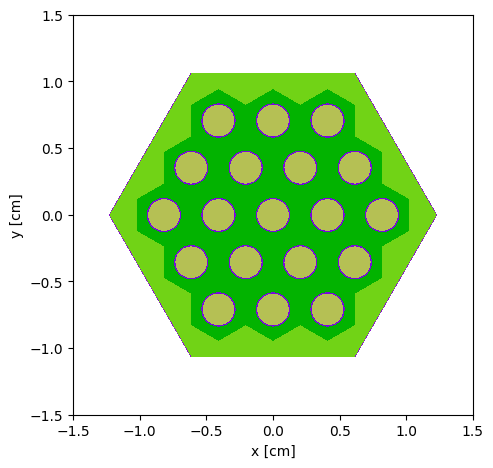

In [18]:
fuel_assembly_universe.plot(pixels =(400,400), width = (3,3))
plt.show()